In [1]:
import os
import numpy as np 
import pandas as pd 
import warnings
from tools.test_bias import test_bias, train_test_bias
from tools.plotting import plot_bias
from tools.bias_utils import add_demographic_data
from tools.loss_functions import get_distance_corrected_mse, get_pearson_corrected_mse, get_kendalls_corrected_mse
from xgb_wrappers.gradient_boosted_trees import GradientBoostedTreesModel
from xgb_wrappers.random_forest import RandomForestModel
import json
import xgboost as xgb
warnings.filterwarnings("ignore")

/Users/ebensen/opt/anaconda3/envs/ai_bias/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
figsize = np.array((25, 6))*1

# Load Data

In [3]:
def to_dmatrix(X, y):
        # get number of columns of np array X
        n_cols = X.shape[1]
        weights = [1.0 for _ in range(n_cols-1)] + [0.0]
        return xgb.DMatrix(X, label=y, feature_weights=weights)

In [4]:
demographics = ['AGE17', 'AGE65', 'CROWD', 'DISABL', 'GROUPQ', 'LIMENG',
            'MINRTY', 'MOBILE', 'MUNIT', 'NOHSDP', 'NOVEH', 'PCI', 'POV',
            'SNGPNT', 'UNEMP']

In [5]:
cols_drop = ['Date', 'FC', 'PenRate', 'NumberOfLanes', 'Dir', 'Lat', 'Long']

raw_data_train = pd.read_csv("./data/final_train_data.csv")
raw_data_test = pd.read_csv("./data/final_test_data.csv")
raw_data_test1 = pd.DataFrame(np.concatenate((raw_data_test.values, np.zeros(raw_data_test.shape[0]).reshape(-1, 1)), axis=1),
                                columns = raw_data_test.columns.append(pd.Index(['fold'])))
raw_data = pd.DataFrame(np.concatenate((raw_data_train.values, raw_data_test1.values), axis=0), 
                        columns = raw_data_train.columns)

raw_data = add_demographic_data(raw_data, demographics)
raw_data = raw_data.dropna()
raw_data_train = raw_data.loc[raw_data.fold!=0, :]
raw_data_test = raw_data.loc[raw_data.fold==0, :]
data = raw_data.drop(cols_drop, axis=1)
if 'Dir' in data.columns:
    one_hot = pd.get_dummies(data[['Dir']])
    data = data.drop(['Dir'], axis = 1)
    data = data.join(one_hot)
week_dict = {"DayOfWeek": {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 
                            'Friday': 5, 'Saturday': 6, 'Sunday': 7}}
data = data.replace(week_dict)

X = data.drop(['Volume'], axis=1)
y = data[['Volume']]

X_test = X.loc[X.fold==0, :]
dem_test = X_test[demographics]
test_ids = X_test[['StationId']].values.reshape((len(X_test), 1))
X_test = X_test.drop(['fold', 'StationId']+demographics, axis = 1).values
y_test = y.loc[X.fold==0, :].values

dtest = to_dmatrix(X_test, y_test)

In [6]:
X_train = X.loc[X.fold!=0, :]
dem_train = X_train[demographics]
train_ids = X_train[['StationId']].values.reshape((len(X_train), 1))
X_train = X_train.drop(['fold', 'StationId']+demographics, axis = 1).values
y_train = y.loc[X.fold!=0, :].values

# XGBoost Model Bias Testing

In [7]:
xgb_path = os.path.join('.', 'base_models', 'xgb', 'base_xgb.model')
xgb_model = xgb.Booster()
xgb_model.load_model(xgb_path)

In [8]:
xgb_model.predict(dtest)

array([23.639128, 25.752493, 24.323109, ..., 86.6062  , 87.55106 ,
       53.84414 ], dtype=float32)

In [9]:
dtest.get_label()

array([ 20. ,  19. ,  33.5, ..., 117. ,  35. ,  16. ], dtype=float32)

In [10]:
path = os.path.join('.', 'base_models', 'xgb')
if not os.path.exists(os.path.join(path, 'xgb_bias_data.csv')):
    xgb_bias_data = test_bias(xgb_model, dtest, dem_test)
    xgb_bias_data.to_csv(os.path.join(path, 'xgb_bias_data.csv'), index=False)
else:
    xgb_bias_data = pd.read_csv(os.path.join(path, 'xgb_bias_data.csv'))
xgb_bias_data

,Demographic,r2_0,r2_1,pval,fdr_corrected_pval,r2_diff,Sig at 0.05,Sig at 0.01,Sig at 0.001
0,AGE17_0.6,0.889269,0.803424,0.0039,0.009692,0.085845,True,True,False
1,AGE17_0.7,0.849358,0.952520,0.0046,0.009857,0.103162,True,True,False
2,AGE17_0.8,0.868732,0.846656,0.5689,0.682680,0.022076,False,False,False
3,AGE17_0.9,0.868687,0.869864,0.9814,0.981400,0.001177,False,False,False
4,AGE65_0.6,0.896947,0.815608,0.0042,0.009692,0.081339,True,True,False
5,AGE65_0.7,0.897986,0.809068,0.0046,0.009857,0.088918,True,True,False
6,AGE65_0.8,0.895842,0.799950,0.0058,0.012000,0.095892,True,False,False
7,AGE65_0.9,0.850791,0.966070,0.0292,0.048667,0.115279,True,False,False
8,CROWD_0.6,0.872549,0.836366,0.3137,0.437721,0.036183,False,False,False
9,CROWD_0.7,0.869873,0.800687,0.1505,0.231538,0.069186,False,False,False


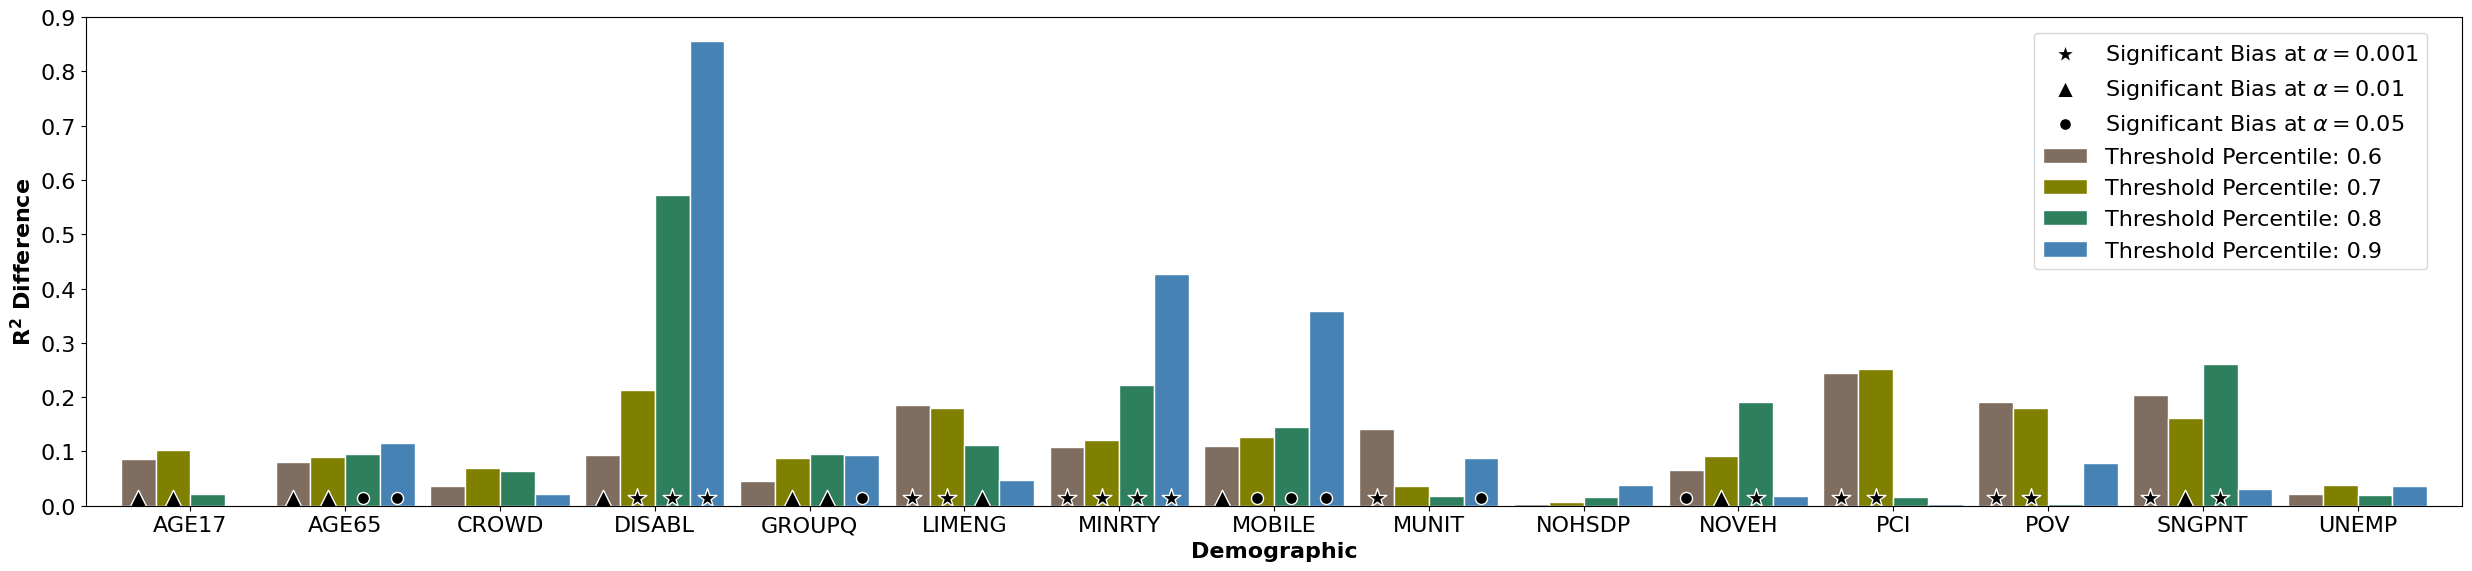

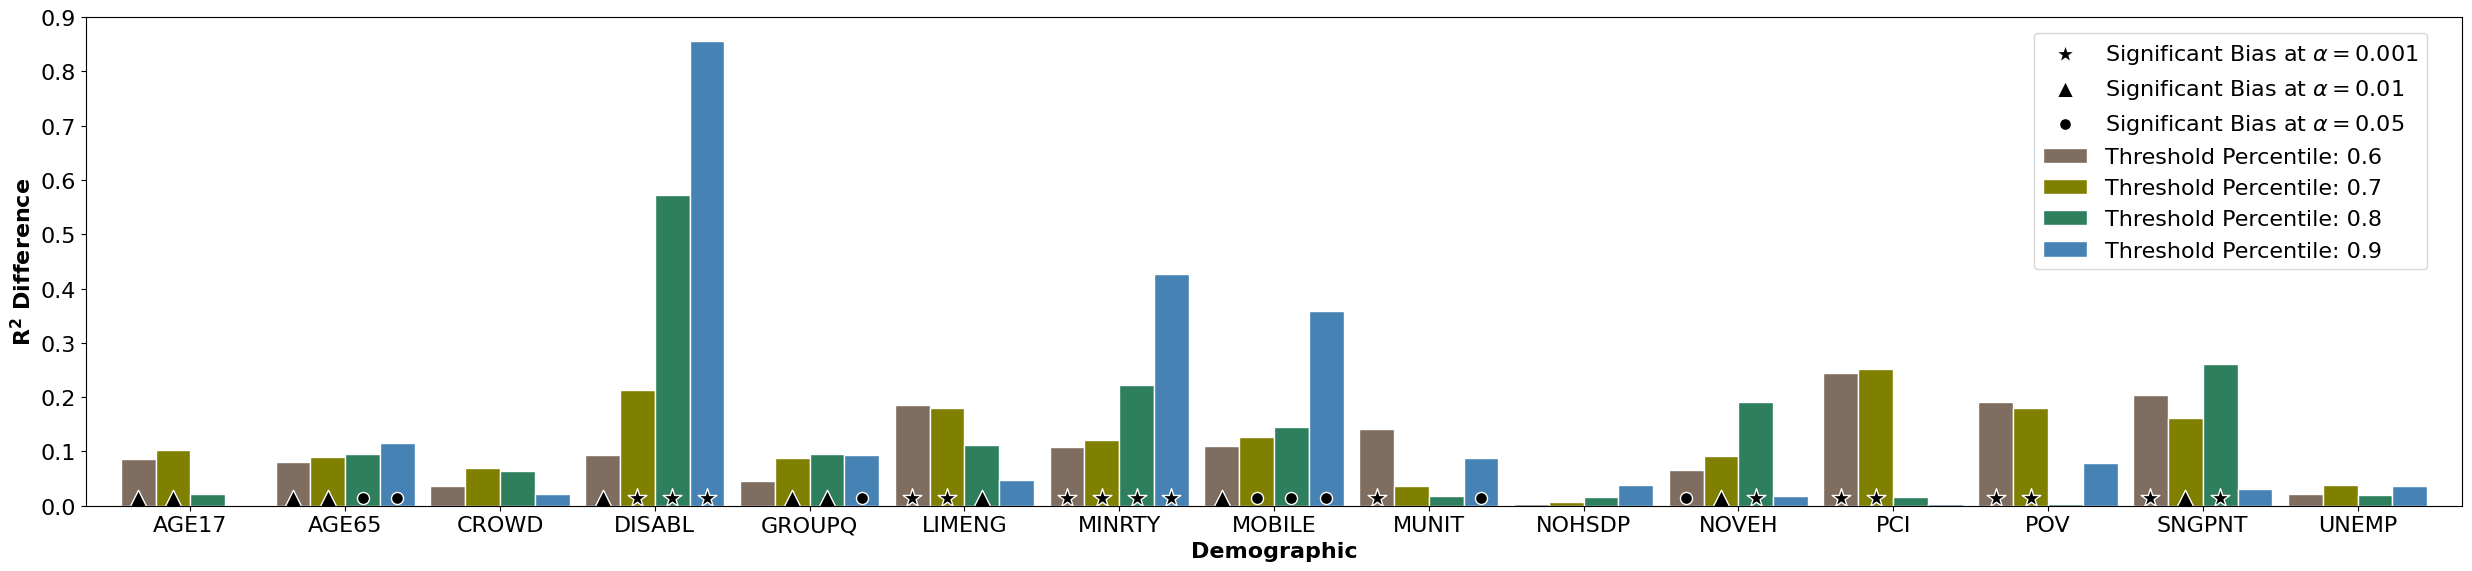

In [11]:
fig_path = os.path.join(path, 'xgb_bias_plots.png')
plot_bias(xgb_bias_data, labels=demographics, savepath=fig_path, xlabel='Demographic', figsize=figsize, barlabels=False)

# Random Forest Model Bias Testing

In [12]:
rf_path = os.path.join('.', 'base_models', 'rf', 'base_rf.model')
rf_model = RandomForestModel()
rf_model.load_model(rf_path)

In [13]:
path = os.path.join('.', 'base_models', 'rf')
if not os.path.exists(os.path.join(path, 'rf_bias_data.csv')):
    rf_bias_data = test_bias(rf_model, dtest, dem_test)
    rf_bias_data.to_csv(os.path.join(path, 'rf_bias_data.csv'), index=False)
else:
    rf_bias_data = pd.read_csv(os.path.join(path, 'rf_bias_data.csv'))
rf_bias_data

,Demographic,r2_0,r2_1,pval,fdr_corrected_pval,r2_diff,Sig at 0.05,Sig at 0.01,Sig at 0.001
0,AGE17_0.6,0.856250,0.763612,0.0092,0.017806,0.092638,True,False,False
1,AGE17_0.7,0.805265,0.951451,0.0030,0.007200,0.146185,True,True,False
2,AGE17_0.8,0.829682,0.834541,0.9249,0.940576,0.004860,False,False,False
3,AGE17_0.9,0.831550,0.855130,0.7248,0.887510,0.023579,False,False,False
4,AGE65_0.6,0.869717,0.754267,0.0011,0.003474,0.115450,True,True,False
5,AGE65_0.7,0.870557,0.746949,0.0014,0.004000,0.123608,True,True,False
6,AGE65_0.8,0.871030,0.728770,0.0020,0.005217,0.142260,True,True,False
7,AGE65_0.9,0.815705,0.919260,0.0844,0.140667,0.103555,False,False,False
8,CROWD_0.6,0.831620,0.880348,0.3068,0.448976,0.048729,False,False,False
9,CROWD_0.7,0.832936,0.808786,0.7240,0.887510,0.024150,False,False,False


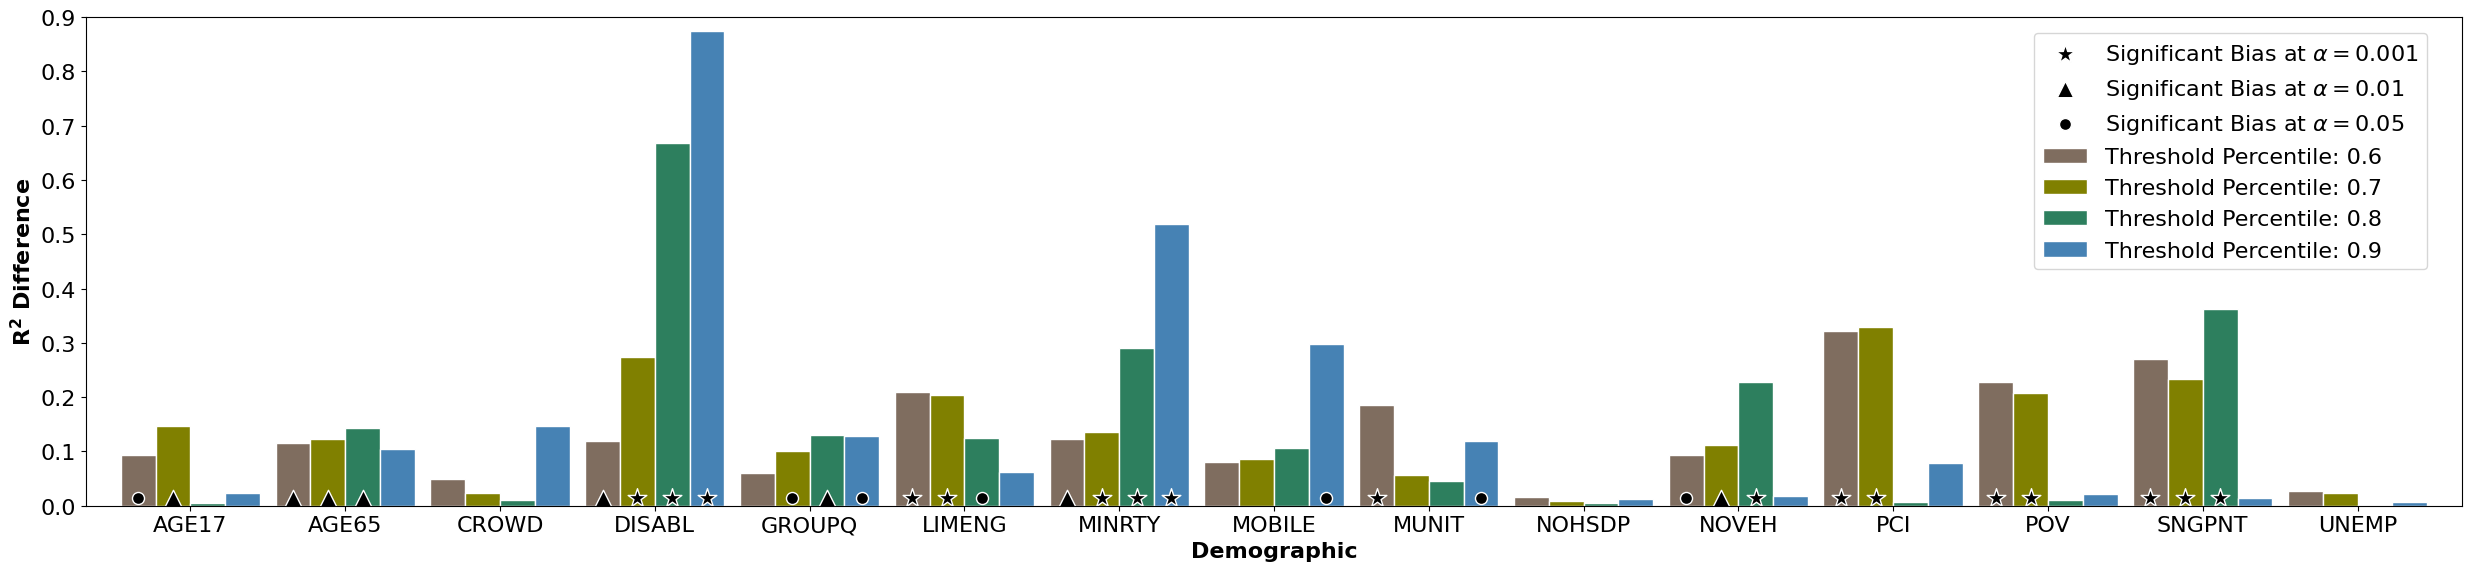

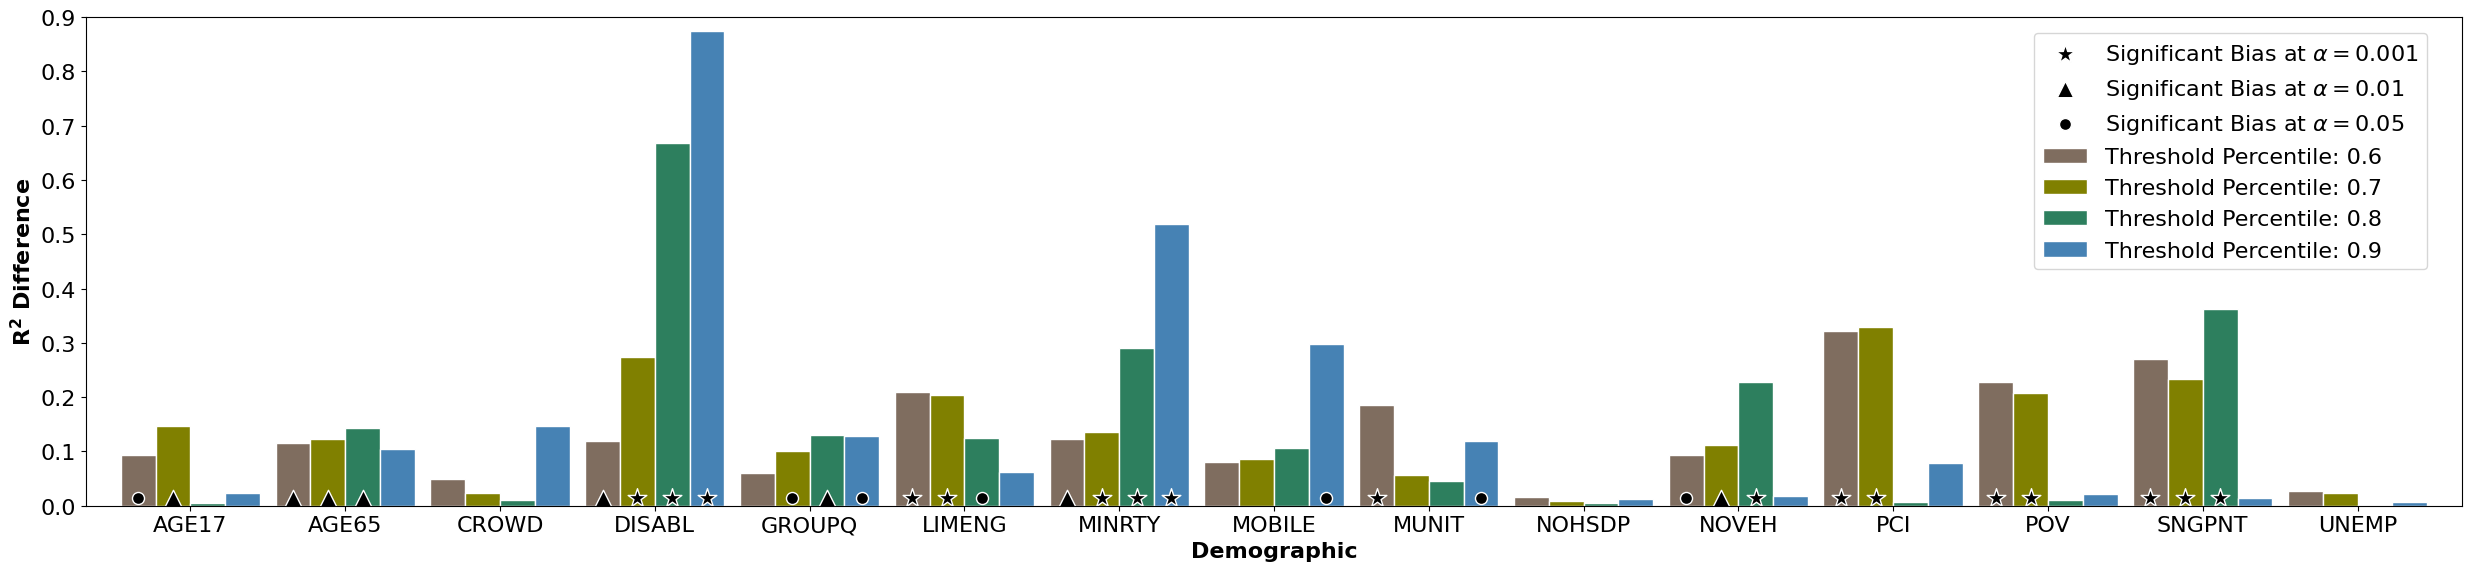

In [14]:
fig_path = os.path.join(path, 'rf_bias_plots.png')
plot_bias(rf_bias_data, labels=demographics, savepath=fig_path, xlabel='Demographic', figsize=figsize, barlabels=False)

# Gradient Boosted Trees Model

In [15]:
gbt_path = os.path.join('.', 'base_models', 'gbt', 'base_gbt.model')
gbt_model = GradientBoostedTreesModel()
gbt_model.load_model(gbt_path)

In [16]:
path = os.path.join('.', 'base_models', 'gbt')
if not os.path.exists(os.path.join(path, 'gbt_bias_data.csv')):
    gbt_bias_data = test_bias(gbt_model, dtest, dem_test)
    gbt_bias_data.to_csv(os.path.join(path, 'gbt_bias_data.csv'), index=False)
else:
    gbt_bias_data = pd.read_csv(os.path.join(path, 'gbt_bias_data.csv'))
gbt_bias_data

,Demographic,r2_0,r2_1,pval,fdr_corrected_pval,r2_diff,Sig at 0.05,Sig at 0.01,Sig at 0.001
0,AGE17_0.6,0.891665,0.816291,0.0056,0.011586,0.075374,True,False,False
1,AGE17_0.7,0.854049,0.959048,0.0053,0.011357,0.104999,True,False,False
2,AGE17_0.8,0.872734,0.838622,0.3500,0.477273,0.034113,False,False,False
3,AGE17_0.9,0.872586,0.877170,0.9295,0.961552,0.004584,False,False,False
4,AGE65_0.6,0.898415,0.821585,0.0050,0.011111,0.076830,True,False,False
5,AGE65_0.7,0.899263,0.815571,0.0033,0.008500,0.083692,True,True,False
6,AGE65_0.8,0.898462,0.805136,0.0066,0.013200,0.093326,True,False,False
7,AGE65_0.9,0.855538,0.965818,0.0297,0.049500,0.110280,True,False,False
8,CROWD_0.6,0.876711,0.840254,0.2966,0.423714,0.036457,False,False,False
9,CROWD_0.7,0.874356,0.794698,0.0895,0.137692,0.079658,False,False,False


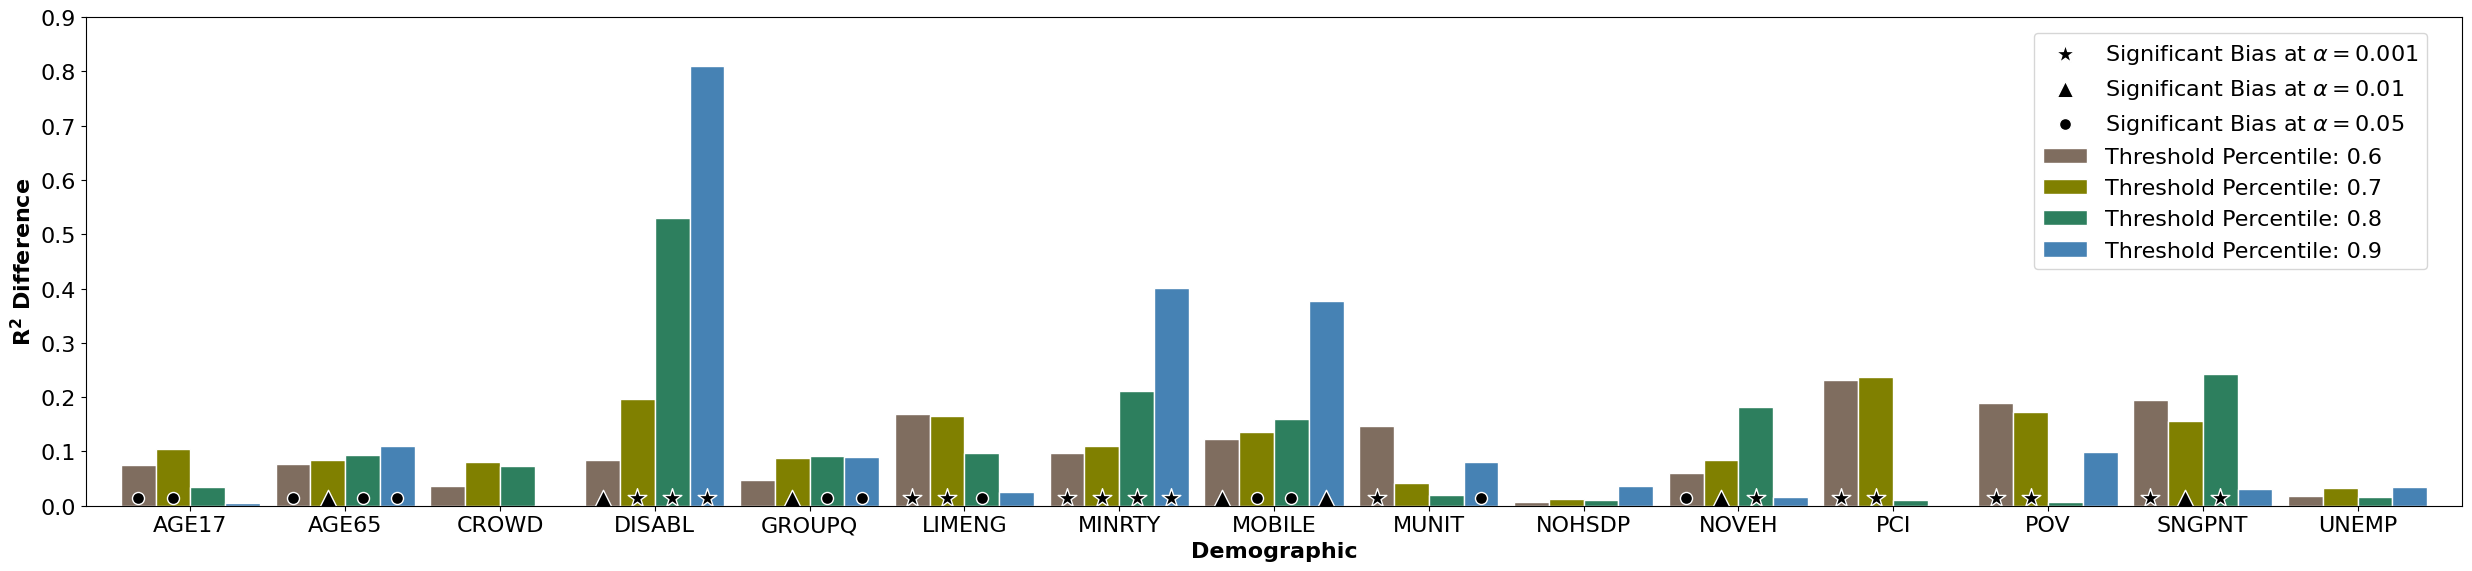

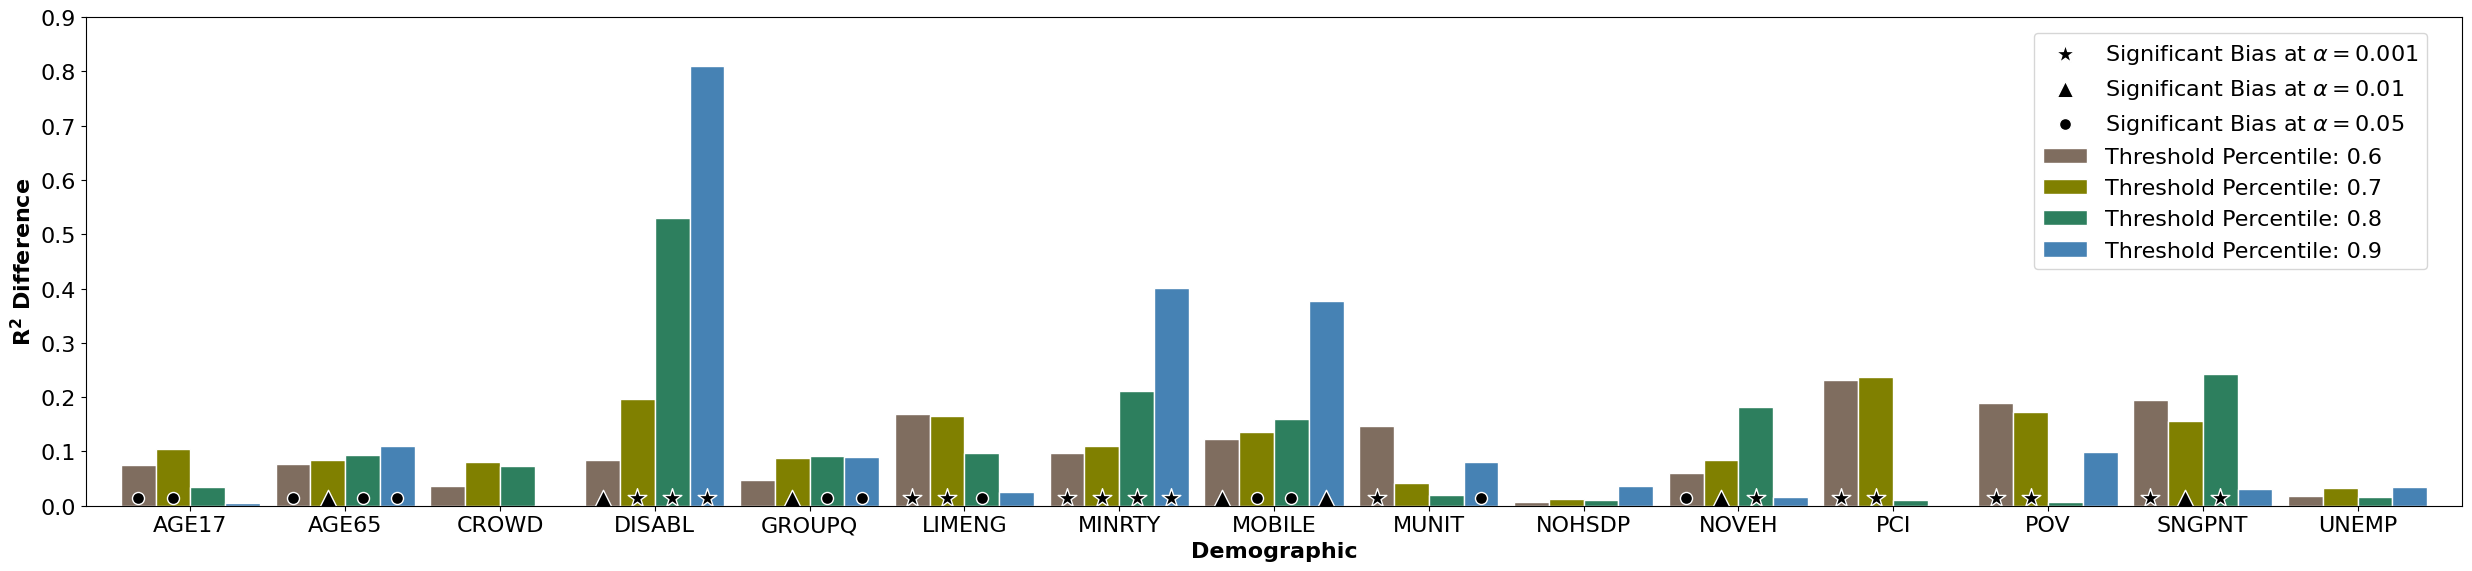

In [17]:
fig_path = os.path.join(path, 'gbt_bias_plots.png')
plot_bias(gbt_bias_data, labels=demographics, savepath=fig_path, xlabel='Demographic', figsize=figsize, barlabels=False)